# Sugestii pentru poze de pisici similare
**bazat pe Product recommendation based on visual similarity de pe kaggle: https://www.kaggle.com/mdiannna/product-recommendation-based-on-visual-similarity?scriptVersionId=41504200**


The goal of this experiment is to make a very basic recommender system: for a given fashion product, we want to recommend products that look similar. 

This kind of recommender system is often used when browsing shopping websites. They usually appear on product pages as a "you may also like" section.

The idea behind this recommender system is simple: if a customer is showing interest towards a product by browsing its page, he may also be interested by products that are similar.


## How to proceed ?

We will used a pre-trained CNN model from Keras to extract the image features.

Then we will compute similarities between the different products using the previously extracted image features.

Other type of information can be used for this purpose such as the product category, size, color, etc. if the data is available, but that is not the case here.

## 0. imports and parameters setup

In [1]:
# !pip3 install keras

In [1]:
# imports

from PIL import Image
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [3]:
# import tensorflow as tf
# ##############
# # Added for my gpu:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#       tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])

#       # tf.config.experimental.set_per_process_memory_fraction(0.5)

#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)
# ##############


In [2]:
# parameters setup

# imgs_path = "../input/style/"

imgs_path = "images/"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

## 1. load the VGG pre-trained model from Keras

Keras module contains several pre-trained models that can be loaded very easily. 

For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that will be able to interpret the image contents.

In this example we will load the VGG16 model trained on imagenet, a big labeled images database.

If we take the whole model, we will get an output containing probabilities to belong to certain classes, but that is not what we want.

We want to retrieve all the information that the model was able to get in the images.

In order to do so, we have to remove the last layers of the CNN which are only used for classes predictions.

In [3]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 2. get the images paths

In [4]:
# files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]
files = [imgs_path + x for x in os.listdir(imgs_path) if ("png" in x) or ("jpg" in x)or ("jpeg" in x)]

print("number of images:",len(files))

number of images: 19


## 3. feed one image into the CNN

First we observe what output we get when putting one image into the CNN.

The following steps are:
- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

In [5]:
# import sys
# from PIL import Image
# sys.modules['Image'] = Image 

# print(Image.__file__)

In [21]:
# import Image
# print(Image.__file__)


/home/mdiannna/Code/ML/LicentaRecommenderSystem/venv/lib/python3.8/site-packages/PIL/Image.py


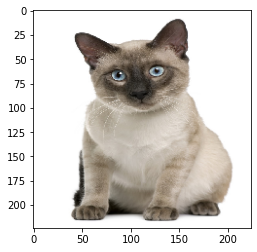

image loaded successfully!


In [10]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [11]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [12]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/block1_conv1/Conv2D (defined at <ipython-input-8-6d3d9d35bd9a>:2) ]] [Op:__inference_predict_function_648]

Function call stack:
predict_function


## 4. feed all the images into the CNN

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [15]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


In [16]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/block1_conv1/Conv2D (defined at <ipython-input-11-6d3d9d35bd9a>:2) ]] [Op:__inference_predict_function_652]

Function call stack:
predict_function


# 5. compute cosine similarities

Now that we have features for every image, we can compute similarity metrics between every image couple.

We will use here the cosine similarity metric.

In [13]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

input/style/cat9_siamese.jpg  \
input/style/cat9_siamese.jpg                       1.000000   
input/style/cat8_siamese.jpg                       0.772812   
input/style/cat11_siamese.jpg                      0.692056   
input/style/cat1.png                               0.337011   
input/style/abysinian5.jpeg                        0.317703   

                               input/style/cat8_siamese.jpg  \
input/style/cat9_siamese.jpg                       0.772812   
input/style/cat8_siamese.jpg                       1.000000   
input/style/cat11_siamese.jpg                      0.761506   
input/style/cat1.png                               0.281932   
input/style/abysinian5.jpeg                        0.316648   

                               input/style/cat11_siamese.jpg  \
input/style/cat9_siamese.jpg                        0.692056   
input/style/cat8_siamese.jpg                        0.761506   
input/style/cat11_siamese.jpg                       1.000000   
input/style/cat1.png                                0.309549   
input/style/abysinian5.jpeg                         0.323317   

                               input/style/cat1.png  \
input/style/cat9_siamese.jpg               0.337011   
input/style/cat8_siamese.jpg               0.281932   
input/style/cat11_siamese.jpg              0.309549   
input/style/cat1.png                       1.000000   
input/style/abysinian5.jpeg                0.304889   

                               input/style/abysinian5.jpeg  \
input/style/cat9_siamese.jpg                      0.317703   
input/style/cat8_siamese.jpg                      0.316648   
input/style/cat11_siamese.jpg                     0.323317   
input/style/cat1.png                              0.304889   
input/style/abysinian5.jpeg                       1.000000   

                               input/style/cat10_siamese.jpg  \
input/style/cat9_siamese.jpg                        0.694572   
input/style/cat8_siamese.jpg                        0.747198   
input/style/cat11_siamese.jpg                       0.679739   
input/style/cat1.png                                0.420794   
input/style/abysinian5.jpeg                         0.280666   

                               input/style/cat11_siamese.jpeg  \
input/style/cat9_siamese.jpg                         0.382286   
input/style/cat8_siamese.jpg                         0.389272   
input/style/cat11_siamese.jpg                        0.482375   
input/style/cat1.png                                 0.333118   
input/style/abysinian5.jpeg                          0.303281   

                               input/style/abysinian6.jpg  \
input/style/cat9_siamese.jpg                     0.401120   
input/style/cat8_siamese.jpg                     0.305172   
input/style/cat11_siamese.jpg                    0.303233   
input/style/cat1.png                             0.575173   
input/style/abysinian5.jpeg                      0.278227   

                               input/style/abysinian1.jpg  \
input/style/cat9_siamese.jpg                     0.468889   
input/style/cat8_siamese.jpg                     0.337508   
input/style/cat11_siamese.jpg                    0.395478   
input/style/cat1.png                             0.392893   
input/style/abysinian5.jpeg                      0.464426   

                               input/style/cat2.jpg  input/style/cat3.jpg  \
input/style/cat9_siamese.jpg               0.371051              0.422384   
input/style/cat8_siamese.jpg               0.314805              0.368702   
input/style/cat11_siamese.jpg              0.338567              0.390382   
input/style/cat1.png                       0.691259              0.464644   
input/style/abysinian5.jpeg                0.260660              0.354461   

                               input/style/abysinian6.jpeg  \
input/style/cat9_siamese.jpg                      0.521295   
input/style/cat8_siamese.jpg                      0.417109   
input/style/cat11_siamese

# 6. retrieve most similar images

The final step is to implement a function that, for any given object, returns the visually most similar objects

In [14]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
#     print("original product:")
    print("cat image:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
#     print("most similar products:")
    print("most similar cats:")
    

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
cat image:


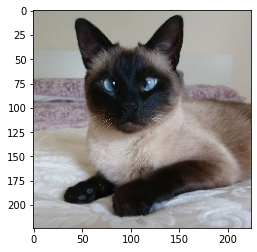

-----------------------------------------------------------------------
most similar cats:


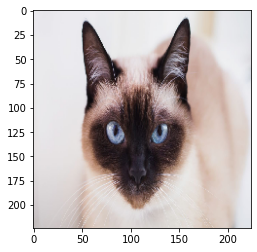

similarity score :  0.80444264


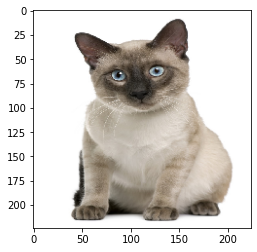

similarity score :  0.7728122


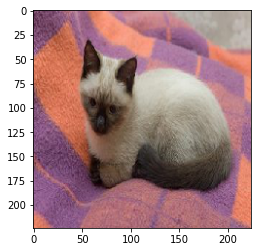

similarity score :  0.76150644


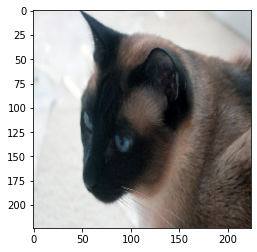

similarity score :  0.7471976


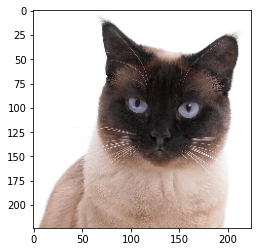

similarity score :  0.7435868


In [15]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
cat image:


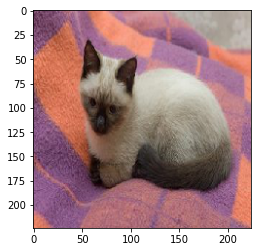

-----------------------------------------------------------------------
most similar cats:


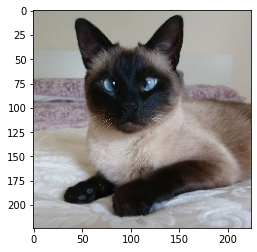

similarity score :  0.76150644


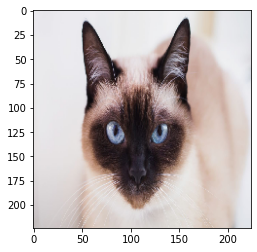

similarity score :  0.7077887


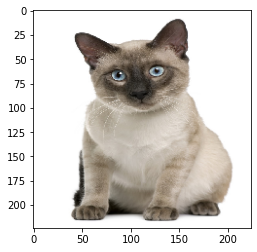

similarity score :  0.6920564


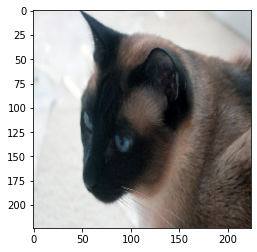

similarity score :  0.67973924


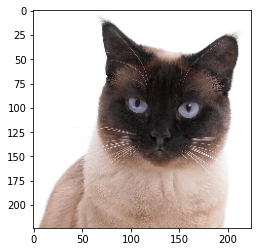

similarity score :  0.662294


In [16]:
retrieve_most_similar_products(files[2])

-----------------------------------------------------------------------
cat image:


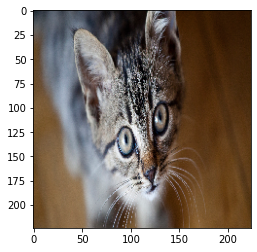

-----------------------------------------------------------------------
most similar cats:


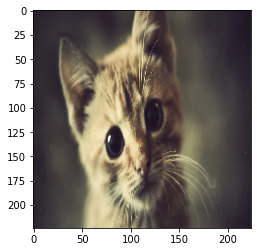

similarity score :  0.69125897


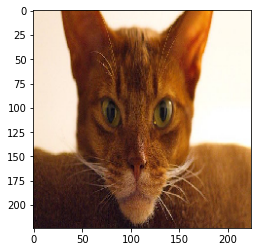

similarity score :  0.5751728


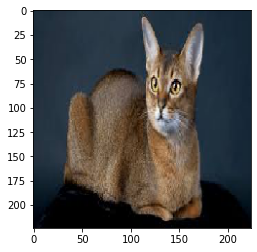

similarity score :  0.5724897


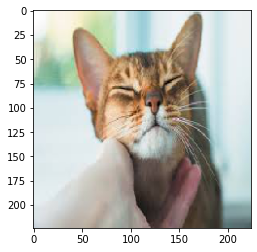

similarity score :  0.5279252


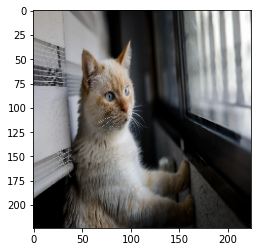

similarity score :  0.46464434


In [15]:
retrieve_most_similar_products(files[3])

-----------------------------------------------------------------------
cat image:


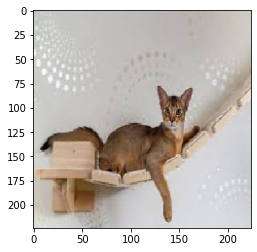

-----------------------------------------------------------------------
most similar cats:


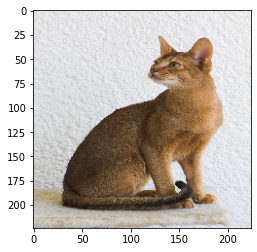

similarity score :  0.4644265


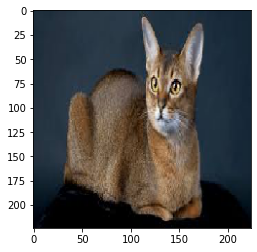

similarity score :  0.35454068


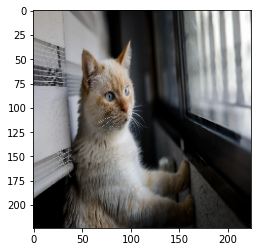

similarity score :  0.354461


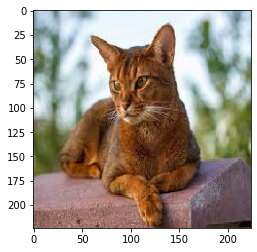

similarity score :  0.3289796


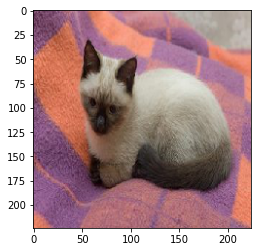

similarity score :  0.32331678


In [17]:
retrieve_most_similar_products(files[4])

-----------------------------------------------------------------------
cat image:


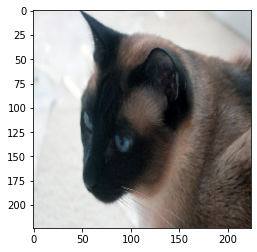

-----------------------------------------------------------------------
most similar cats:


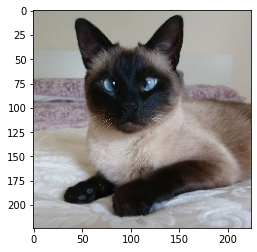

similarity score :  0.74719787


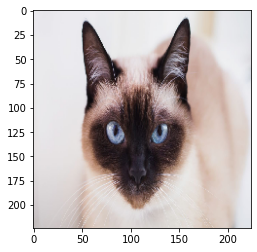

similarity score :  0.7293899


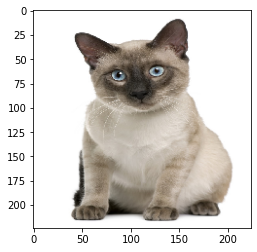

similarity score :  0.69457144


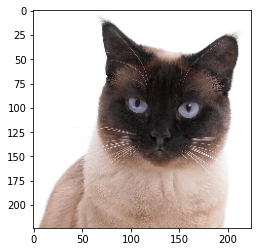

similarity score :  0.6925009


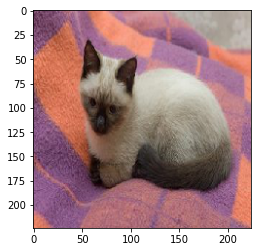

similarity score :  0.6797395


In [17]:
retrieve_most_similar_products(files[5])

-----------------------------------------------------------------------
cat image:


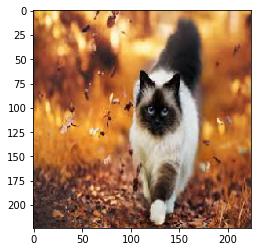

-----------------------------------------------------------------------
most similar cats:


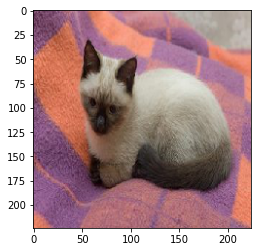

similarity score :  0.48237494


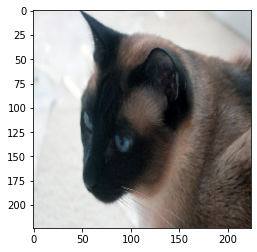

similarity score :  0.42918995


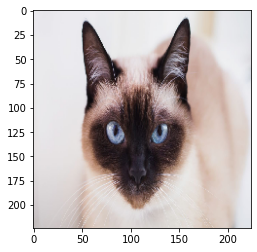

similarity score :  0.425075


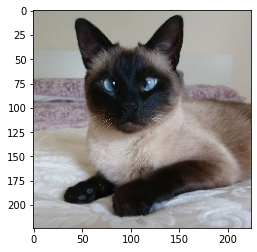

similarity score :  0.38927203


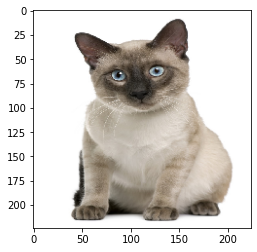

similarity score :  0.38228595


In [18]:
retrieve_most_similar_products(files[6])

-----------------------------------------------------------------------
cat image:


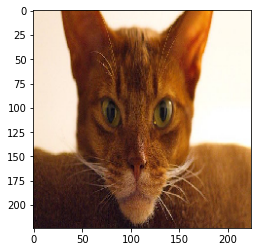

-----------------------------------------------------------------------
most similar cats:


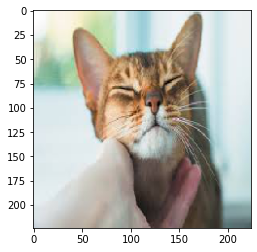

similarity score :  0.6519413


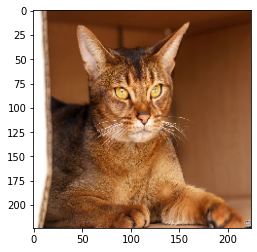

similarity score :  0.6183538


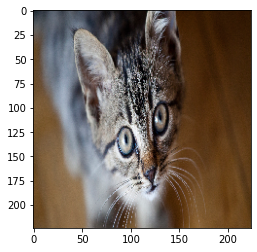

similarity score :  0.5751728


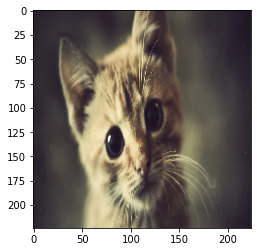

similarity score :  0.55035585


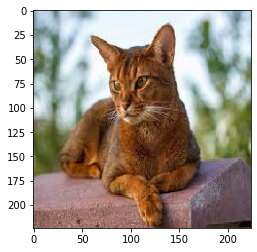

similarity score :  0.5407241


In [19]:
retrieve_most_similar_products(files[7])

# Conclusion
We saw above that this very basic recommender system is able to find similar products accurately: most of the time the retrieved products have the same purpose and even look very similar.

This could be incorporated directly into a website using a web framework such as Flask.